# BTC vs Gold in terms of maximum supply

This notebook investigates how Bitcoin relates to Gold.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

# The following style setup will be moved to a common style file
# TODO: Fix font
# TODO: Fix plot padding (left-border of the plot should be same position for all plots)
matplotlib.style.use('ggplot')
matplotlib.rcParams.update({
    'font.size': 15,
    'figure.facecolor': '1',
    'figure.figsize': (10, 4),
    'savefig.pad_inches': 0.2
})

def default_ax_style():
    fig = plt.figure()
    ax = fig.subplots(1,1)
    ax.ticklabel_format(style='plain')
    return ax

First, let's define two constants that denote the maximum supply of the two assets. For Bitcoin, there will ever only be 21 million units, as specified in the source code. For gold, we use an estimate from this article that declares the reserved supply below the ground to about 55000 tons.

In [2]:
TOTAL_BITCOINS = 21_000_000
TOTAL_GOLD_TONS = 190_040 + 55_000
OUNCES_PER_TON = 32_000  # TODO: is this correct? short ton vs ton?

Next, we need to collect some timeseries data in order to compare the two assets.

## Gold

Let's start with gold. We will take data points from articles with various points in time and store them in a DataFrame. After that we will do a monthly resampling and interpolation.

In [3]:
gold = pd.DataFrame.from_dict([{
    "date": "31-12-2019", # own estimate
    "gold_tons": 198500
}, {
    "date": "31-12-2018", # own estimate
    "gold_tons": 194000
}, {
    "date": "31-12-2017", # https://www.gold.org/about-gold/gold-supply/gold-mining/how-much-gold
    "gold_tons": 190040
}, {
    "date": "31-12-2013", # https://www.bbc.com/news/magazine-21969100
    "gold_tons": 171300
}, {
    "date": "31-12-2016", # https://www.usgs.gov/faqs/how-much-gold-has-been-found-world?qt-news_science_products=0#qt-news_science_products
    "gold_tons": 187000 
}, {
    "date": "31-12-2006", # https://www.welt.de/print-welt/article216681/Das-ganze-Gold-der-Welt.html
    "gold_tons": 155500 
}, {
    "date": "31-12-2007", # https://www.forbes.com/sites/afontevecchia/2010/11/19/how-many-olympic-sized-swimming-pools-can-we-fill-with-billionaire-gold/#23543ddf69f1
    "gold_tons": 157000 
}, {
    "date": "31-12-1950", # https://www.forbes.com/sites/afontevecchia/2010/11/19/how-many-olympic-sized-swimming-pools-can-we-fill-with-billionaire-gold/#23543ddf69f1
    "gold_tons": 52000    # "Sixty-six per cent of that is said to have been mined since 1950."
}])
gold.date = pd.to_datetime(gold.date)
gold = gold.set_index("date").resample("M").mean().interpolate()

This gives as a crude estimate of how the global gold supply changed since 1950:

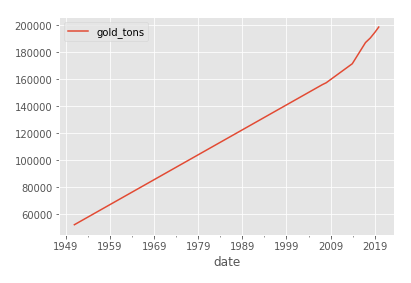

In [4]:
gold.plot(ax=default_ax_style());

As you can see, there is quite an inflation of Gold.

Next, we will get the annual gold prices from a CSV API endpoint:

In [5]:
from urllib.request import urlopen

gold_price = pd.read_csv(urlopen("https://datahub.io/core/gold-prices/r/annual.csv"))

# datahab.io gold-prices is missing 2018. So we'll add a datapoint:
gold_price = gold_price.append(pd.DataFrame.from_dict([{
    "Date": "2018-12-31",
    "Price": 1255
}]))

gold_price.Date = pd.to_datetime(gold_price.Date)
gold_price = gold_price.set_index("Date")
gold_price = gold_price.resample("M").mean().interpolate()

## Bitcoin

For Bitcoin, we can acquire all relevant data from the blockchain.info API. As a start, let's grab the total bitcoin supply since 2009:

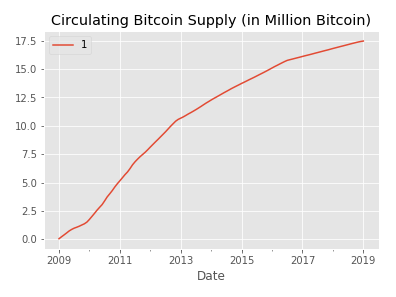

In [6]:
from urllib.request import urlopen

btc_supply = pd.read_csv(urlopen("https://api.blockchain.info/charts/total-bitcoins?timespan=all&format=csv"),
                         header=None)
btc_supply["Date"] = pd.to_datetime(btc_supply[0])
btc_supply = btc_supply.set_index("Date")
btc_supply = btc_supply.resample("M").mean().interpolate()
(btc_supply / 1e6).plot(ax=default_ax_style(), title='Circulating Bitcoin Supply (in Million Bitcoin)');

Secondly, we grab the market price as well:

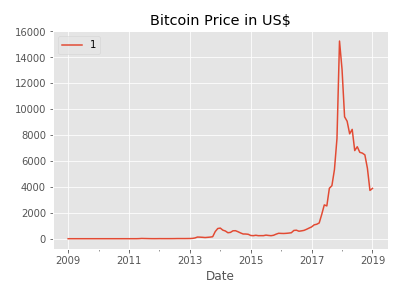

In [7]:
btc_price = pd.read_csv(urlopen("https://api.blockchain.info/charts/market-price?timespan=all&format=csv"),
                         header=None)
btc_price["Date"] = pd.to_datetime(btc_price[0])
btc_price = btc_price.set_index("Date").resample("M").mean().interpolate()
btc_price.plot(ax=default_ax_style(), title='Bitcoin Price in US$');

## Total Gold Marketcap

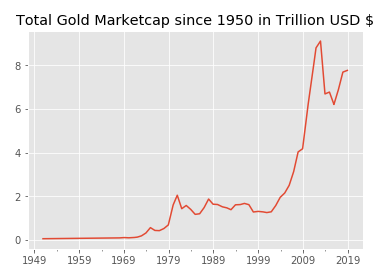

In [8]:
(gold_price.Price * gold.gold_tons * OUNCES_PER_TON / 1e12).plot(
    ax=default_ax_style(),
    title="Total Gold Marketcap since 1950 in Trillion USD $"
);

## Total Bitcoin Marketcap since 2009

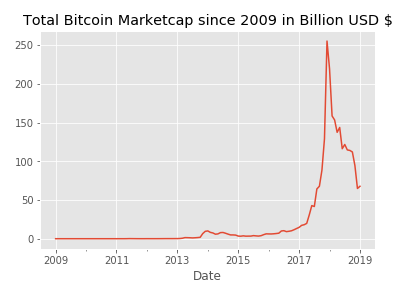

In [9]:
(btc_price[1] * btc_supply[1] / 1e9).plot(
    ax=default_ax_style(),
    title="Total Bitcoin Marketcap since 2009 in Billion USD $"
);

## Relation between both marketcaps

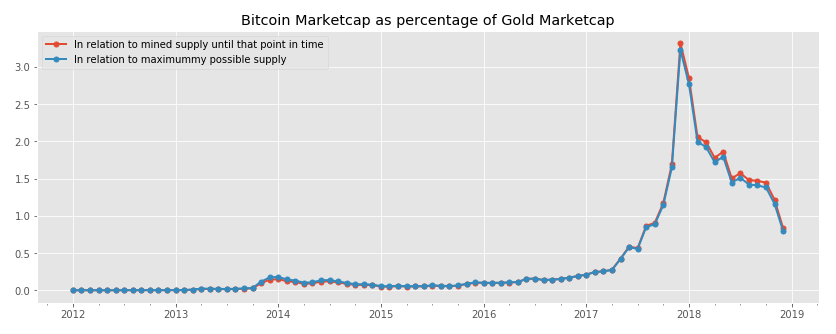

In [10]:
btc_vs_gold = ((btc_price[1] * btc_supply[1]) / (gold_price.Price * gold.gold_tons * OUNCES_PER_TON) * 100)
btc_vs_gold_max = ((btc_price[1] * TOTAL_BITCOINS) / (gold_price.Price * TOTAL_GOLD_TONS * OUNCES_PER_TON) * 100)
pd.DataFrame({
 "In relation to mined supply until that point in time": btc_vs_gold,
 "In relation to maximummy possible supply": btc_vs_gold_max
})["2012":].plot(figsize=(14,5), marker='.', markersize=10, lw=2,
        title='Bitcoin Marketcap as percentage of Gold Marketcap');

As you can see, the 2017 hyperbullmarket is pretty dominant in this graph. The first real takeaway is that the Bitcoin marketcap compared to Gold is fairly high, around 0.8 % at the beginning of 2019.